In [1]:
import time
import numpy as np
import pandas as pd
import hydroeval as he
import json
import matplotlib.pyplot as plt
import sys
from datetime import date
from datetime import datetime, timedelta

sys.path.insert(0, './CFE')
import bmi_cfe_open
import bmi_cfe_enkf_peturb

sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI


(750.0, 780.0)

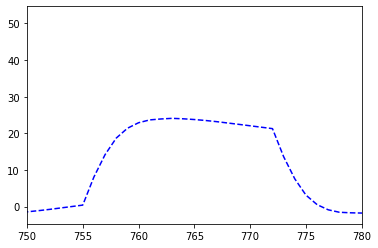

In [2]:
# GET OBSERVATIONS
cfe_obs = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_obs.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
with open(cfe_obs.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
OBSERVATIONS_LIST = []
OBSERVATIONS_LIST_2 = []
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE
    cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
    cfe_obs.update()
    OBSERVATIONS_LIST.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)
    
    
# for i, precip in enumerate(df_forcing['APCP_surface_NoObsEnd']): #i is RAINRATE
#     cfe_obs.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) 
#     cfe_obs.update()
#     OBSERVATIONS_LIST_2.append(cfe_obs.get_value('land_surface_water__runoff_depth') + np.sin(i/5) * 2)   
   
#OBSERVATIONS_LIST_2 = OBSERVATIONS_LIST[0:769] # getting observations for EnKF without 18hour forecast

cfe_obs.finalize()
plt.plot(OBSERVATIONS_LIST_2,color = 'green',)
plt.plot(OBSERVATIONS_LIST,color = 'blue', linestyle='dashed')
plt.xlim(750,780)

In [3]:
## Open BMI's for each file
#cfe_open = bmi_cfe_open.BMI_CFE()
cfe_open = bmi_cfe_enkf_peturb.BMI_CFE() #One BMI to rule them all
cfe_peturbed = bmi_cfe_enkf_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_enkf_peturb.BMI_CFE() #true model in the end with updated state vars

enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()

In [4]:
# Initialize Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_synthetic.json')
enkf.initialize(cfg_file='./Assimilation/EnKF_config-synthetic.json') # Need to create this still

initialized 10


In [5]:
print(bmi_cfe_open)
print(bmi_cfe_enkf_peturb)
print(Bmi_da_ENKF_forSBMI)

<module 'bmi_cfe_open' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_open.py'>
<module 'bmi_cfe_enkf_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_enkf_peturb.py'>
<module 'Bmi_da_ENKF_forSBMI' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./Assimilation\\Bmi_da_ENKF_forSBMI.py'>


In [6]:
# with open(cfe_open.forcing_file, 'r') as f:
#     df_forcing = pd.read_csv(f)
    
# print(df_forcing)
#plt.plot(df_forcing['APCP_surface'])

#values = df_forcing['APCP_surface']
#print(values)

In [7]:
#Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
cfeAnalysis = []
cfeEnKF = []

n_loop = 3

# ## Loop through 100 different precipitation files for forcing 
# for loop in range(n_loop):
#     p = 'APCP_surface_' + str(loop)
#     print(p)
 
   
## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface_0']): #i is RAINRATE

    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip*3)

    obs = OBSERVATIONS_LIST[i]
    enkf.set_value('validity', 1)
    
    if i>769:
        enkf.set_value('validity', 0)

    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()

    # Get state vars from Peturbed. These are values as enkf uses
    soil_storage_avail = cfe_peturbed.get_value('soil_storage_avail_m')
    soil_reservoir_storage_deficit = cfe_peturbed.get_value('soil_reservoir_storage_deficit_out_m')
    surface_runoff = cfe_peturbed.get_value('land_surface_water__runoff_volume_flux')

    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')

    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) # For plotting

    # Set EnKF value to usgs, mean, and covariance. Get value from it then update
    enkf.set_value('soil_storage_avail_m', soil_storage_avail) #setting soil storage in enkf
    enkf.set_value('soil_reservoir_storage_deficit_m', soil_reservoir_storage_deficit) #setting soil storage in enkf
    enkf.set_value('surface_runoff_depth_m', surface_runoff) #setting soil storage in enkf

    enkf.set_value('x', np.array([outflow_peturb_mean]))
    enkf.set_value('P', np.array([outflow_peturb_covar]))
    enkf.set_value('z', np.array([obs]))
    enkf.update()

    # For plotting
    outflow_enkf = enkf.get_value('enkf')
    cfeEnKF.append(outflow_enkf)

    # Get new EnKF state vars to give back to CFE Analysis
    state_transition_soil_storage = enkf.get_value('soil_storage_avail_m')
    state_transition_soil_res     = enkf.get_value('soil_reservoir_storage_deficit_updated_m')
    state_transition_runoff_factor= enkf.get_value('surface_runoff_ratio')

    # Set value for CFE analysis based on the state variable change from the EnKF factor to get true streamflow
    cfe_analysis.set_value('soil_storage_avail_m', state_transition_soil_storage)    
    cfe_analysis.set_value('soil_reservoir_storage_deficit_m', state_transition_soil_res)  
    cfe_analysis.set_value('state_var_change_runoff',state_transition_runoff_factor)
    cfe_analysis.update() #get new streamflow value based on state var change

    # For plotting
    outflow_analysis = cfe_analysis.get_value('land_surface_water__runoff_depth')
    cfeAnalysis.append(outflow_analysis) 

    # Get values from new CFE analysis to put back into CFE Peturbed to keep look and EnKF going
    cfe_updated_everything_soil_storage = cfe_analysis.get_value('soil_storage_avail_m')
    cfe_updated_everything_soil_res = cfe_analysis.get_value('soil_reservoir_storage_deficit_m')
    cfe_updated_everything_runoff = cfe_analysis.get_value('state_var_change_runoff')

    # Set value from CFE analysis state variables back into CFE Peturbed to continue EnKF loop
    cfe_peturbed.set_value('soil_storage_avail_m', cfe_updated_everything_soil_storage)
    cfe_peturbed.set_value('soil_reservoir_storage_deficit_m', cfe_updated_everything_soil_res)
    cfe_peturbed.set_value('state_var_change_runoff', cfe_updated_everything_runoff)
    
   
        

# Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
enkf.finalize()

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3121136221931379
EnKF Code predicted, X Post [9.40799689]
surface_runoff_ratio [2.16166509]
Leftover vol 0.0
surface _runoff [2.16166509]
***********over estimaiton ratio [1.]
Observation BMI [9.14803171]
CFE [25.69010261]
enkf [9.40799689]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2957114578598735
EnKF Code predicted, X Post [16.50465387]
surface_runoff_ratio [3.86476543]
Leftover vol 0.0
surface _runoff [3.86476543]
***********over estimaiton ratio [1.]
Observation BMI [16.75252741]
CFE [39.49969614]
enkf [16.50465387]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.28072802840953426
EnKF Code predicted, X Post [22.19989563]
surface_runoff_ratio [2.13581786]
Leftover vol [30.90791805]
surface _runoff [2.13581786]
***********over estimaiton ratio [0.41801562]
Observation BMI [22.40183725]
CFE [53.10781368]
enkf [22.19989563]
Beginning

EnKF Code predicted, X Post [1.59772867]
surface_runoff_ratio [2.44385334]
Leftover vol 0.0
surface _runoff [2.44385334]
***********over estimaiton ratio [1.]
Observation BMI [0.88095149]
CFE [23.21567788]
enkf [1.59772867]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2788329941391109
EnKF Code predicted, X Post [0.99667684]
surface_runoff_ratio [0.06200366]
Leftover vol [31.36545156]
surface _runoff [0.06200366]
***********over estimaiton ratio [0.03079763]
Observation BMI [1.04406761]
CFE [32.3621284]
enkf [0.99667684]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26542606272433555
EnKF Code predicted, X Post [1.65003814]
surface_runoff_ratio [1.24311788]
Leftover vol 0.0
surface _runoff [1.24311788]
***********over estimaiton ratio [1.]
Observation BMI [1.03358117]
CFE [13.59251828]
enkf [1.65003814]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2531680364876415
EnKF Code predic

EnKF Code predicted, X Post [7.26762572]
surface_runoff_ratio [1.35503307]
Leftover vol 0.0
surface _runoff [1.35503307]
***********over estimaiton ratio [1.]
Observation BMI [7.49292225]
CFE [16.81533554]
enkf [7.26762572]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21352690982891087
EnKF Code predicted, X Post [7.91555999]
surface_runoff_ratio [1.2511957]
Leftover vol 0.0
surface _runoff [1.2511957]
***********over estimaiton ratio [1.]
Observation BMI [7.3846982]
CFE [16.08299614]
enkf [7.91555999]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2056840228236998
EnKF Code predicted, X Post [7.32700101]
surface_runoff_ratio [1.28597263]
Leftover vol 0.0
surface _runoff [1.28597263]
***********over estimaiton ratio [1.]
Observation BMI [7.20225426]
CFE [17.59695915]
enkf [7.32700101]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1985175729185722
EnKF Code predicted, X Post [7.13856

EnKF Code predicted, X Post [-0.86171452]
surface_runoff_ratio [0.00154489]
Leftover vol 0.0
surface _runoff [0.00154489]
***********over estimaiton ratio [1.]
Observation BMI [-1.47298295]
CFE [0.01913715]
enkf [-0.86171452]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22087793796261546
EnKF Code predicted, X Post [-0.98559477]
surface_runoff_ratio [0.00154686]
Leftover vol 0.0
surface _runoff [0.00154686]
***********over estimaiton ratio [1.]
Observation BMI [-1.7076792]
CFE [0.01180406]
enkf [-0.98559477]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.22789779952908784
EnKF Code predicted, X Post [-0.68766534]
surface_runoff_ratio [0.00154864]
Leftover vol 0.0
surface _runoff [0.00154864]
***********over estimaiton ratio [1.]
Observation BMI [-1.87351525]
CFE [0.02047963]
enkf [-0.68766534]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.234803556792876
EnKF Code predicted, X Post 

Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29323104648356924
EnKF Code predicted, X Post [6.7839748]
surface_runoff_ratio [1.9325165]
Leftover vol 0.0
surface _runoff [1.9325165]
***********over estimaiton ratio [1.]
Observation BMI [6.41908756]
CFE [26.07054303]
enkf [6.7839748]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.27847655924522996
EnKF Code predicted, X Post [9.09496564]
surface_runoff_ratio [2.55445936]
Leftover vol 0.0
surface _runoff [2.55445936]
***********over estimaiton ratio [1.]
Observation BMI [8.89455495]
CFE [25.42779576]
enkf [9.09496564]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26499696724137756
EnKF Code predicted, X Post [10.29795443]
surface_runoff_ratio [2.91462606]
Leftover vol 0.0
surface _runoff [2.91462606]
***********over estimaiton ratio [1.]
Observation BMI [10.34055647]
CFE [28.83436449]
enkf [10.29795443]
Beginning-----------------------

EnKF Code predicted, X Post [2.86368212]
surface_runoff_ratio [0.28424127]
Leftover vol 0.0
surface _runoff [0.28424127]
***********over estimaiton ratio [1.]
Observation BMI [1.55873198]
CFE [3.56423737]
enkf [2.86368212]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17617229718025562
EnKF Code predicted, X Post [1.0978669]
surface_runoff_ratio [0.14551594]
Leftover vol 0.0
surface _runoff [0.14551594]
***********over estimaiton ratio [1.]
Observation BMI [0.32957033]
CFE [1.87457736]
enkf [1.0978669]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18391882634825008
EnKF Code predicted, X Post [-0.38631495]
surface_runoff_ratio [0.04726234]
Leftover vol 0.0
surface _runoff [0.04726234]
***********over estimaiton ratio [1.]
Observation BMI [-0.46852133]
CFE [0.56391598]
enkf [-0.38631495]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.19153943959887676
EnKF Code predicted, X Post [-0.1

EnKF Code predicted, X Post [0.71049046]
***********under estimaiton ratio [31.40297069]
Observation BMI [1.66781789]
CFE [0.02262494]
enkf [0.71049046]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2063924533209589
EnKF Code predicted, X Post [0.90853073]
***********under estimaiton ratio [36.50894861]
Observation BMI [1.86021156]
CFE [0.02488515]
enkf [0.90853073]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.21364776912088446
EnKF Code predicted, X Post [1.06261818]
***********under estimaiton ratio [57.40466845]
Observation BMI [1.97924643]
CFE [0.01851101]
enkf [1.06261818]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.220785153428534
EnKF Code predicted, X Post [0.88780592]
***********under estimaiton ratio [44.83882667]
Observation BMI [2.02017731]
CFE [0.01979994]
enkf [0.88780592]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2278065231607

EnKF Code predicted, X Post [20.8168082]
surface_runoff_ratio [1.37355791]
Leftover vol [26.45859046]
surface _runoff [1.37355791]
***********over estimaiton ratio [0.44033067]
Observation BMI [20.97571803]
CFE [47.27539866]
enkf [20.8168082]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.17063084664137473
EnKF Code predicted, X Post [21.10321164]
surface_runoff_ratio [2.74510428]
Leftover vol 0.0
surface _runoff [2.74510428]
***********over estimaiton ratio [1.]
Observation BMI [21.19755278]
CFE [26.16490694]
enkf [21.10321164]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16647154274620857
EnKF Code predicted, X Post [21.18560815]
surface_runoff_ratio [3.27552788]
Leftover vol 0.0
surface _runoff [3.27552788]
***********over estimaiton ratio [1.]
Observation BMI [21.3487926]
CFE [32.08765896]
enkf [21.18560815]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.16267209324111587
EnKF Co

EnKF Code predicted, X Post [20.96102659]
surface_runoff_ratio [1.51592783]
Leftover vol [29.16185802]
surface _runoff [1.51592783]
***********over estimaiton ratio [0.41819274]
Observation BMI [21.68596637]
CFE [50.12288461]
enkf [20.96102659]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.1915820834055164
EnKF Code predicted, X Post [21.37988304]
surface_runoff_ratio [1.54101599]
Leftover vol [23.85527402]
surface _runoff [1.54101599]
***********over estimaiton ratio [0.47263864]
Observation BMI [21.3137461]
CFE [45.23515705]
enkf [21.37988304]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.18560914993165645
EnKF Code predicted, X Post [21.18099371]
surface_runoff_ratio [1.39028512]
Leftover vol [24.82866279]
surface _runoff [1.39028512]
***********over estimaiton ratio [0.46035974]
Observation BMI [20.9768099]
CFE [46.0096565]
enkf [21.18099371]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_f

EnKF Code predicted, X Post [-0.48070056]
surface_runoff_ratio [0.00159155]
Leftover vol 0.0
surface _runoff [0.00159155]
***********over estimaiton ratio [1.]
Observation BMI [-0.47027807]
CFE [0.0194154]
enkf [-0.48070056]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2547418510822592
EnKF Code predicted, X Post [-0.10131443]
surface_runoff_ratio [0.00159151]
Leftover vol 0.0
surface _runoff [0.00159151]
***********over estimaiton ratio [1.]
Observation BMI [-0.07529743]
CFE [0.01893642]
enkf [-0.10131443]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.26121127185213067
EnKF Code predicted, X Post [0.02034087]
surface_runoff_ratio [0.00159126]
Leftover vol 0.0
surface _runoff [0.00159126]
***********over estimaiton ratio [1.]
Observation BMI [0.32348875]
CFE [0.02175554]
enkf [0.02034087]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2675755354563334
EnKF Code predicted, X Post [0.

EnKF Code predicted, X Post [0.40313062]
***********under estimaiton ratio [17.60148861]
Observation BMI [0.7151262]
CFE [0.02290321]
enkf [0.40313062]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3321937921277702
EnKF Code predicted, X Post [-0.04188823]
surface_runoff_ratio [0.00145801]
Leftover vol 0.0
surface _runoff [0.00145801]
***********over estimaiton ratio [1.]
Observation BMI [0.32875864]
CFE [0.02059368]
enkf [-0.04188823]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.33740427073178025
EnKF Code predicted, X Post [-0.07541081]
surface_runoff_ratio [0.00145606]
Leftover vol 0.0
surface _runoff [0.00145606]
***********over estimaiton ratio [1.]
Observation BMI [-0.06997954]
CFE [0.01942359]
enkf [-0.07541081]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.3425300556388944
EnKF Code predicted, X Post [-0.02066728]
surface_runoff_ratio [0.00145389]
Leftover vol 0.0
surface _

soil_storage_deficit_from CFE 0.2854364100617264
EnKF Code predicted, X Post [-0.30361782]
surface_runoff_ratio [0.00118171]
Leftover vol 0.0
surface _runoff [0.00118171]
***********over estimaiton ratio [1.]
Observation BMI [-0.87951805]
CFE [0.01281193]
enkf [-0.30361782]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.29140690628509647
EnKF Code predicted, X Post [-0.3059792]
surface_runoff_ratio [0.00118415]
Leftover vol 0.0
surface _runoff [0.00118415]
***********over estimaiton ratio [1.]
Observation BMI [-0.50627607]
CFE [0.01747168]
enkf [-0.3059792]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.2972803551091987
EnKF Code predicted, X Post [0.08909445]
***********under estimaiton ratio [5.55868606]
Observation BMI [-0.11225202]
CFE [0.01602797]
enkf [0.08909445]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.303058333990471
EnKF Code predicted, X Post [5.78082602]
surface_runof

EnKF Code predicted, X Post [-1.27553453]
surface_runoff_ratio [0.00133123]
Leftover vol 0.0
surface _runoff [0.00133123]
***********over estimaiton ratio [1.]
Observation BMI [-1.97957558]
CFE [0.01802885]
enkf [-1.27553453]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39534480976378783
EnKF Code predicted, X Post [-0.42362405]
surface_runoff_ratio [0.00132857]
Leftover vol 0.0
surface _runoff [0.00132857]
***********over estimaiton ratio [1.]
Observation BMI [-1.96335311]
CFE [0.01605651]
enkf [-0.42362405]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.39952880048581785
EnKF Code predicted, X Post [-0.27252089]
surface_runoff_ratio [0.00132568]
Leftover vol 0.0
surface _runoff [0.00132568]
***********over estimaiton ratio [1.]
Observation BMI [-1.86818815]
CFE [0.01935442]
enkf [-0.27252089]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.40364478255279757
EnKF Code predicted, X Po

EnKF Code predicted, X Post [-0.88901827]
surface_runoff_ratio [0.00115039]
Leftover vol 0.0
surface _runoff [0.00115039]
***********over estimaiton ratio [1.]
Observation BMI [-1.98207614]
CFE [0.01511721]
enkf [-0.88901827]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5003918480803748
EnKF Code predicted, X Post [-0.72054986]
surface_runoff_ratio [0.00114244]
Leftover vol 0.0
surface _runoff [0.00114244]
***********over estimaiton ratio [1.]
Observation BMI [-1.91952833]
CFE [0.01622578]
enkf [-0.72054986]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5028683522739794
EnKF Code predicted, X Post [-0.8679951]
surface_runoff_ratio [0.0011344]
Leftover vol 0.0
surface _runoff [0.0011344]
***********over estimaiton ratio [1.]
Observation BMI [-1.77987744]
CFE [0.01169533]
enkf [-0.8679951]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5053046021432743
EnKF Code predicted, X Post [-0.

EnKF Code predicted, X Post [-0.3469245]
surface_runoff_ratio [0.00080423]
Leftover vol 0.0
surface _runoff [0.00080423]
***********over estimaiton ratio [1.]
Observation BMI [0.41451708]
CFE [0.01060098]
enkf [-0.3469245]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5736500454364746
EnKF Code predicted, X Post [8.65639477]
surface_runoff_ratio [1.72835015]
Leftover vol 0.0
surface _runoff [1.72835015]
***********over estimaiton ratio [1.]
Observation BMI [8.09141174]
CFE [16.43928097]
enkf [8.65639477]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.5346517202000878
EnKF Code predicted, X Post [14.00423792]
surface_runoff_ratio [3.08964611]
Leftover vol 0.0
surface _runoff [3.08964611]
***********over estimaiton ratio [1.]
Observation BMI [14.19190485]
CFE [36.5356939]
enkf [14.00423792]
Beginning----------------------------
self.f 1.0
soil_storage_deficit_from CFE 0.4990215594982122
EnKF Code predicted, X Post [19.0

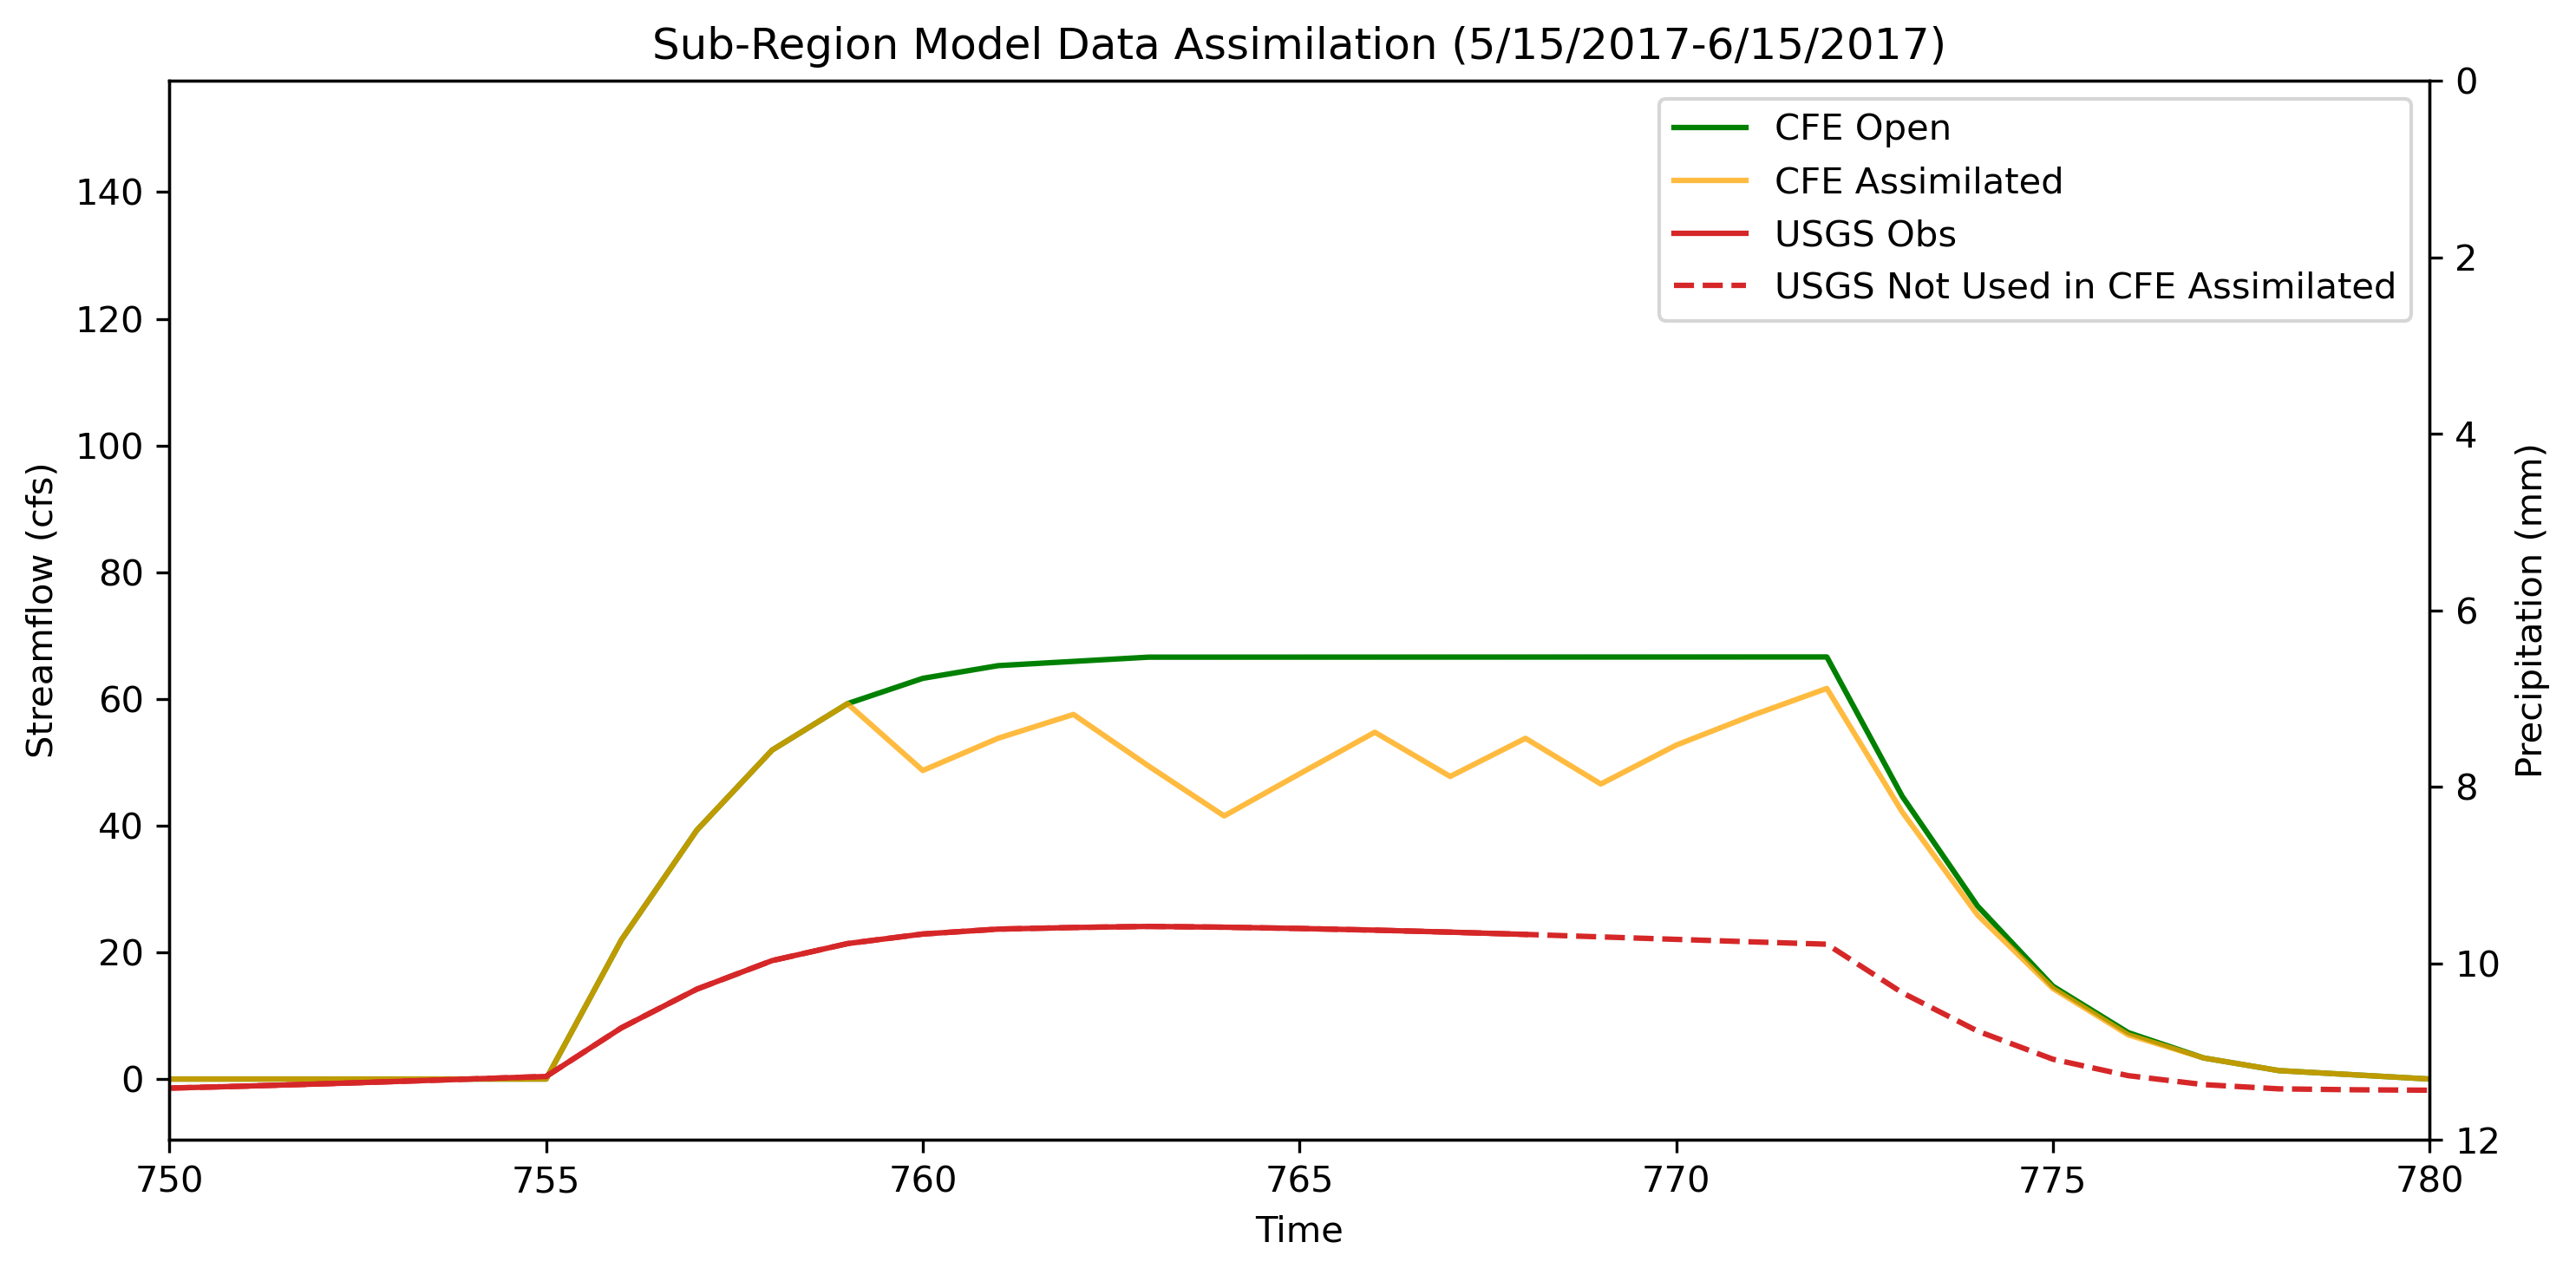

In [18]:
istart_plot=0
istart_plot_2=769
iend_plot=786
x = list(range(istart_plot, iend_plot))

Date_list = []
df_forcing['time'] = pd.to_datetime(df_forcing['time'], infer_datetime_format=True) 

fig, ax1 = plt.subplots(figsize = (10,5), dpi=300)

ax2 = ax1.twinx()

ax1.set_xlabel('Time')
ax1.set_ylabel('Streamflow (cfs)')
ax2.set_ylabel('Precipitation (mm)')
ax2.set_ylim(0,12,1)
ax2.invert_yaxis()
#ax1.set_ylim(0,50,1)
plt.xlim(750,780)

plt.title('Sub-Region Model Data Assimilation (5/15/2017-6/15/2017)')
#Precip = ax2.bar(x, df_forcing['APCP_surface'][istart_plot:iend_plot],width=1,alpha=0.7, color="tab:blue", label = 'Precip')
#ax1.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:orange', label = 'CFE Peturbed')
Open, = ax1.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
Analysis, = ax1.plot(x, cfeAnalysis[istart_plot:iend_plot], color = 'orange', alpha=0.75, label = 'CFE Assimilated')
Obs, = ax1.plot(OBSERVATIONS_LIST[istart_plot:769], color = 'tab:red', label = 'USGS Obs')
Obs2, = ax1.plot(OBSERVATIONS_LIST[istart_plot:iend_plot], color = 'tab:red', linestyle='dashed', label = 'USGS Not Used in CFE Assimilated')
#ax1.plot(x, cfeEnKF[istart_plot:iend_plot], color = 'tab:blue', label = 'EnKF')

#ax1.set_xlim([date(2017, 5, 15), date(2017, 6, 15)]) ## Customize date range for all plots
#ax1.tick_params(axis='x', labelrotation = 45)

plt.legend(handles = [Open,Analysis,Obs,Obs2], loc='upper right', bbox_to_anchor=(0.5, 0.5, 0.5, 0.5))

#plt.savefig("WorkingDA_7-19.png")
fig.tight_layout()
ax1.margins(x=0)

plt.show()


In [9]:
df=pd.DataFrame({"obs":OBSERVATIONS_LIST,"cfeAnalysis":cfeAnalysis,"cfeOpen":cfeOpen})
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,obs,cfeAnalysis,cfeOpen
0,9.148032,27.481335,27.481335
1,16.752527,49.132918,49.132918
2,22.401837,48.962407,64.956276
3,25.803301,44.848888,74.118403
4,27.774125,41.952065,79.117138
...,...,...,...
781,-1.530973,0.010046,0.010046
782,-1.246911,0.010113,0.010113
783,-0.912735,0.010181,0.010181
784,-0.541764,0.010250,0.010250


In [10]:
# CFE open eval
nse_open=he.evaluator(he.nse,df["obs"],df["cfeOpen"])
pbias=he.evaluator(he.pbias,df["obs"],df["cfeOpen"])
kge_open, r_open, alpha_open, beta_open = he.evaluator(he.kge, df["obs"],df["cfeOpen"])
print("r_open=",r_open[0])
print("KGE_open=",kge_open[0])
print("NSE_open=", nse_open[0])
print("PBias=", pbias[0])

# CFE Analysis
nse_analysis=he.evaluator(he.nse,df["obs"],df["cfeAnalysis"])
pbias_analysis=he.evaluator(he.pbias,df["obs"],df["cfeAnalysis"])
kge_analysis, r_analysis, alpha_analysis, beta_analysis = he.evaluator(he.kge, df["obs"],df["cfeAnalysis"])
print("r_analysis=",r_analysis[0])
print("KGE_analysis=",kge_analysis[0])
print("NSE_analysis=", nse_analysis[0])
print("PBias=", pbias_analysis[0])

print("mean_obs=",np.mean(df["obs"]))
print("STD_obs=",np.std(df["obs"]))
print("mean_open=",np.mean(df["cfeOpen"]))
print("STD_open=",np.std(df["cfeOpen"]))
print("mean_analysis=",np.mean(df["cfeAnalysis"]))
print("STD_analysis=",np.std(df["cfeAnalysis"]))

r_open= 0.9922796717668682
KGE_open= 0.06321812077097766
NSE_open= 0.3619184561078962
PBias= 66.66970823527441
r_analysis= 0.9606048697585113
KGE_analysis= 0.32322604509095076
NSE_analysis= 0.6283151520122041
PBias= 49.09152261064914
mean_obs= 7.364020014124951
STD_obs= 11.26933696902018
mean_open= 22.094076061819823
STD_open= 32.955062126095925
mean_analysis= 14.46521363780831
STD_analysis= 21.03237571586038
